In [1]:
import os
import sys
import logging
from gymnasium.wrappers import RescaleAction, ClipAction

# Setting path for all packages
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/chatt07/Desktop/new_context_env/aniket_clones/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

# Importing Config Files
from general_noise_q_env_config import (
    params,
    backend_params,
    runtime_options,
    apply_parametrized_circuit,
    get_backend_parametrised,
    get_parameterised_circuit_context,
    get_instruction_durations
)
# Importing Environment
from rl_qoc.general_noise_quantum_environment import GeneralNoiseQuantumEnvironment
# Importing PPO
from rl_qoc.ppo_cleanrl import PPO_CleanRL
from rl_qoc.helper_functions import load_from_yaml_file

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
Backend with Aer Noise Model needs to reset
Circuit Context should either be parametrised and take phi, or be reset
"""

from itertools import product
import sys
from typing import Dict, Optional, List, Any, TypeVar, SupportsFloat, Union

import numpy as np
from gymnasium.spaces import Box

# Qiskit imports
from qiskit import transpile
from qiskit.circuit import (
    QuantumCircuit,
    QuantumRegister,
    ParameterVector,
    CircuitInstruction,
)
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit.transpiler import Layout
from qiskit_aer.backends import AerSimulator
from qiskit_aer.backends.aerbackend import AerBackend
from qiskit_aer.noise import NoiseModel
from qiskit_dynamics import DynamicsBackend
from qiskit_ibm_runtime import EstimatorV2

from qiskit_ibm_runtime import IBMBackend as RuntimeBackend

from rl_qoc.helper_functions import (
    projected_statevector,
    get_instruction_timings,
    get_q_env_config,
)
from rl_qoc.qconfig import QEnvConfig, QiskitConfig
from rl_qoc.base_parametrised_q_env import (
    GateTarget,
    BaseParametrisedQuantumEnvironment,
)
from rl_qoc.custom_jax_sim import JaxSolver

import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

ObsType = TypeVar("ObsType")
ActType = TypeVar("ActType")


def create_array(circ_trunc, batchsize, n_actions):
    arr = np.empty((circ_trunc,), dtype=object)
    for i in range(circ_trunc):
        arr[i] = np.zeros((i + 1, batchsize, n_actions))
    return arr


class GeneralNoiseQuantumEnvironment(BaseParametrisedQuantumEnvironment):

    def __init__(
        self,
        params,
        backend_params,
        runtime_options,
        apply_parametrized_circuit,
        get_backend_parametrised,
        get_parameterised_circuit_context,
        get_instruction_durations,
        gamma,
        circuit_param_distribution,
        phi_low,
        phi_max,
        num_params,
        discrete_history_length,
        optimal_error_precision,
        training_steps_per_gate: Union[List[int], int] = 1500,
        intermediate_rewards: bool = False,
    ):
        self.params = params
        self.backend_params = backend_params
        self.runtime_options = runtime_options
        self.apply_parametrized_circuit = apply_parametrized_circuit
        self.get_backend_parametrised = get_backend_parametrised
        self.get_parameterised_circuit_context = get_parameterised_circuit_context
        self.get_instruction_durations = get_instruction_durations
        self.gamma = gamma
        self._training_steps_per_gate = training_steps_per_gate
        self._intermediate_rewards = intermediate_rewards
        self.circuit_fidelity_history = []
        self.phi_low = phi_low
        self.phi_max = phi_max
        self.num_params = num_params
        self.optimal_error_precision = optimal_error_precision
        self.example_phi = phi_max
        self.circuit_param_distribution = circuit_param_distribution

        # Making Example Backend and Circuit Context
        self.example_backend = self.get_backend_parametrised(
            phi=self.example_phi,
            gamma=self.gamma,
            print_noise_model=True,
            **self.backend_params,
        )
        self.backend_config = QiskitConfig(
            self.apply_parametrized_circuit,
            self.example_backend,
            estimator_options=(
                self.runtime_options
                if isinstance(self.example_backend, RuntimeBackend)
                else None
            ),
            # parametrized_circuit_kwargs=parametrized_circ_args,
        )
        self.q_env_config = QEnvConfig(
            backend_config=self.backend_config, **self.params
        )
        self.q_env_config.backend_config.parametrized_circuit_kwargs = {
            "target": self.q_env_config.target,
            "backend": self.q_env_config.backend,
        }
        self.q_env_config.backend_config.instruction_durations_dict = (
            self.get_instruction_durations(self.q_env_config.backend)
        )
        print_circuit = True
        self.circuit_context = self.get_parameterised_circuit_context(
            self.example_phi, print_circuit, self.example_backend
        )

        # Define target register and nearest neighbor register for truncated circuits
        self.circ_tgt_register = QuantumRegister(
            bits=[
                self.circuit_context.qubits[i]
                for i in self.q_env_config.physical_qubits
            ],
            name="tgt",
        )

        # Adjust target register to match it with circuit context
        self.target_instruction = CircuitInstruction(
            self.q_env_config.target["gate"],
            (qubit for qubit in self.circ_tgt_register),
        )
        self._tgt_instruction_counts = self.circuit_context.data.count(
            self.target_instruction
        )
        if self.tgt_instruction_counts == 0:
            raise ValueError("Target gate not found in circuit context")

        self._parameters = [
            ParameterVector(f"a_{j}", self.q_env_config.n_actions)
            for j in range(self.tgt_instruction_counts)
        ]

        # Store time and instruction indices where target gate is played in circuit
        try:
            self._op_start_times = self.circuit_context.op_start_times
        except AttributeError:
            self._op_start_times = get_instruction_timings(self.circuit_context)

        ### Very important, keep after _op_start_times ###
        super().__init__(self.q_env_config)

        self._target_instruction_timings = []
        for i, instruction in enumerate(self.circuit_context.data):
            if instruction == self.target_instruction:
                self._target_instruction_timings.append(self._op_start_times[i])

        self._param_values = create_array(
            self.tgt_instruction_counts, self.batch_size, self.action_space.shape[-1]
        )
        self.observation_space = Box(
            low=np.array([-1.0]), high=np.array([1.0]), dtype=np.float32
        )  # multiply by pi for actual values
        self.phi_bound = 0.0

        self.discrete_reward_history = np.ones((discrete_history_length, num_params))
        self.discrete_obs_vals = np.linspace(
            self.observation_space.low, self.observation_space.high, self.num_params
        ).flatten()
        print(f"Observation Vals: {self.discrete_obs_vals}")

    def define_target_and_circuits(self):
        """
        Define target gate and circuits for calibration
        """

        assert "gate" in self.config.target, "Target should be a gate"

        # Build registers for all relevant qubits
        circ_nn_register, circ_anc_register = (
            QuantumRegister(
                bits=[self.circuit_context.qubits[i] for i in qubits],
                name=reg_name,
            )
            for reg_name, qubits in zip(
                ["nn", "anc"],
                [self.physical_neighbor_qubits, self.physical_next_neighbor_qubits],
            )
        )
        tgt_register = QuantumRegister(len(self.physical_target_qubits), name="tgt")
        layouts = [
            Layout(
                {
                    tgt_register[i]: self.physical_target_qubits[i]
                    for i in range(tgt_register.size)
                }
            )
            for _ in range(self.tgt_instruction_counts)
        ]
        nn_registers, anc_registers = [
            [QuantumRegister(1, name=f"{name}_{i}") for i in range(reg.size)]
            for name, reg in zip(["nn", "anc"], [circ_nn_register, circ_anc_register])
        ]
        # Create mapping between circuit context qubits and custom circuit associated single qubit registers
        mapping = {
            circ_reg[i]: reg[i]
            for circ_reg, reg in zip(
                [circ_nn_register, self.circ_tgt_register, circ_anc_register],
                [nn_registers, tgt_register, anc_registers],
            )
            for i in range(circ_reg.size)
        }

        # Initialize custom and baseline circuits for each target gate (by default only contains target qubits)
        custom_circuits, baseline_circuits = [
            [
                QuantumCircuit(tgt_register, name=name + str(i))
                for i in range(self.tgt_instruction_counts)
            ]
            for name in ["c_circ_trunc_", "b_circ_trunc_"]
        ]
        # Build sub-circuit contexts: each circuit goes until target gate and preserves nearest neighbor operations
        for i in range(self.tgt_instruction_counts):  # Loop over target gates
            counts = 0
            for start_time, instruction in zip(
                self._op_start_times, self.circuit_context.data
            ):  # Loop over instructions in circuit context

                # Check if instruction involves target or nearest neighbor qubits
                involves_target_qubits = any(
                    [
                        qubit in reg
                        for reg in [self.circ_tgt_register, circ_nn_register]
                        for qubit in instruction.qubits
                    ]
                )
                if involves_target_qubits:
                    involved_qubits = [
                        qubit
                        for qubit in instruction.qubits
                        if qubit not in self.circ_tgt_register
                    ]
                else:
                    involved_qubits = []

                # If instruction involves target or nn qubits and happens before target gate, add it to custom circuit

                if (
                    counts <= i or start_time <= self._target_instruction_timings[i]
                ) and involves_target_qubits:
                    for qubit in involved_qubits:
                        if (
                            mapping[qubit] not in custom_circuits[i].qregs
                        ):  # Add register if not already added
                            baseline_circuits[i].add_register(mapping[qubit])
                            custom_circuits[i].add_register(mapping[qubit])
                            if (
                                self.circuit_context.layout.final_layout is not None
                            ):  # Update physical layout
                                layouts[i].add(
                                    mapping[qubit][0],
                                    self.circuit_context.layout.final_layout[qubit],
                                )
                            else:
                                layouts[i].add(
                                    mapping[qubit][0],
                                    self.circuit_context.qubits.index(qubit),
                                )

                    baseline_circuits[i].append(
                        instruction.operation,
                        (
                            (
                                mapping[q][0]
                                if q not in self.circ_tgt_register
                                else mapping[q]
                            )
                            for q in instruction.qubits
                        ),
                    )
                    if instruction != self.target_instruction:
                        custom_circuits[i].append(
                            instruction.operation,
                            (
                                (
                                    mapping[q][0]
                                    if q not in self.circ_tgt_register
                                    else mapping[q]
                                )
                                for q in instruction.qubits
                            ),
                        )
                    else:  # Add custom instruction in place of target gate
                        try:
                            self.parametrized_circuit_func(
                                custom_circuits[i],
                                self.parameters[counts],
                                tgt_register,
                                **self._func_args,
                            )
                        except TypeError:
                            raise TypeError("Failed to call parametrized_circuit_func")
                        counts += 1
            # custom_circuits[i] = remove_unused_wires(custom_circuits[i])
            # baseline_circuits[i] = remove_unused_wires(baseline_circuits[i])

        target = GateTarget(
            self.config.target["gate"],
            self.physical_target_qubits,
            self.config.n_reps,
            baseline_circuits,
            tgt_register,
            layouts,
        )
        return target, custom_circuits, baseline_circuits

    def reset(
        self,
        override_obs: Optional[np.ndarray] = None,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """Reset the Environment, chooses a new input state"""
        super().reset(seed=seed)

        if self.circuit_param_distribution == "uniform":
            self.phi_bound = np.random.uniform(
                low=self.observation_space.low, high=self.observation_space.high
            )
        if self.circuit_param_distribution == "normal":
            self.phi_bound = np.random.normal(loc=0.0, scale=0.5, size=None)
            self.phi_bound = np.clip(
                self.phi_bound,
                a_min=self.observation_space.low,
                a_max=self.observation_space.high,
            )
        if self.circuit_param_distribution == "simple_discrete":
            self.phi_bound = np.random.choice(
                a=self.discrete_obs_vals, size=len(self.observation_space.shape), replace=True
            )
        if self.circuit_param_distribution == "moving_discrete":
            self.prob_weights = (np.mean(
                self.discrete_reward_history, axis=0
            ) + np.log10(self.optimal_error_precision)) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            self.phi_bound = np.random.choice(
                a=self.discrete_obs_vals, size=len(self.observation_space.shape), replace=True, p=self.prob_weights
            )
        if override_obs is not None:
            self.phi_bound = override_obs
        self._param_values = create_array(
            self.tgt_instruction_counts, self.batch_size, self.action_space.shape[0]
        )
        self._inside_trunc_tracker = 0

        self.phi_rad = (
            self.phi_bound * (self.phi_max - self.phi_low) / 2 + (self.phi_max + self.phi_low) / 2
        )  # scaling factor for radian parameters
        assert self.phi_rad <= self.phi_max
        assert self.phi_rad >= self.phi_low

        # Making Backend and Circuit Context
        self.step_backend = self.get_backend_parametrised(
            phi=self.phi_rad,
            gamma=self.gamma,
            print_noise_model=False,
            **self.backend_params,
        )
        self.step_backend_config = QiskitConfig(
            self.apply_parametrized_circuit,
            self.step_backend,
            estimator_options=(
                self.runtime_options
                if isinstance(self.step_backend, RuntimeBackend)
                else None
            ),
            # parametrized_circuit_kwargs=parametrized_circ_args,
        )
        self.step_q_env_config = QEnvConfig(
            backend_config=self.step_backend_config, **self.params
        )
        self.step_q_env_config.backend_config.parametrized_circuit_kwargs = {
            "target": self.step_q_env_config.target,
            "backend": self.step_q_env_config.backend,
        }
        self.step_q_env_config.backend_config.instruction_durations_dict = (
            self.get_instruction_durations(self.step_q_env_config.backend)
        )
        print_circuit = False
        self.step_circuit_context = self.get_parameterised_circuit_context(
            self.phi_rad, print_circuit, self.step_backend
        )

        # Redefining Targets based on new phi
        self.extract_from_config(
            self.step_q_env_config
        )  # effectively reruns super.__init__() functionalities

        return self._get_obs(), self._get_info()

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:

        # trunc_index tells us which circuit truncation should be trained
        # Dependent on global_step and method select_trunc_index
        trunc_index = self.trunc_index
        # Figure out if in middle of param loading or should compute the final reward (step_status < trunc_index or ==)
        step_status = self._inside_trunc_tracker
        self._step_tracker += 1

        if self._episode_ended:
            terminated = True
            return (
                self.reset()[0],
                np.zeros(self.batch_size),
                terminated,
                False,
                self._get_info(),
            )

        if trunc_index >= self.tgt_instruction_counts:
            # raise IndexError(f"Circuit does contain only {self.tgt_instruction_counts} target gates and step"
            #                  f" function tries to access gate nb {trunc_index} ")
            truncated = True
            return (
                self.reset()[0],
                np.zeros(self.batch_size),
                False,
                truncated,
                self._get_info(),
            )

        params, batch_size = np.array(action), len(np.array(action))
        if batch_size != self.batch_size:
            raise ValueError(
                f"Action batch size {batch_size} does not match environment batch size {self.batch_size}"
            )
        self._param_values[trunc_index][step_status] = params
        params = np.reshape(
            np.vstack([param_set for param_set in self._param_values[trunc_index]]),
            (self.batch_size, (trunc_index + 1) * self.action_space.shape[-1]),
        )
        if step_status < trunc_index:  # Intermediate step within the circuit truncation
            self._inside_trunc_tracker += 1
            terminated = False

            if self._intermediate_rewards:
                reward = self.perform_action(params)
                obs = reward  # Set observation to obtained reward (might not be the smartest choice here)
                return obs, reward, terminated, False, self._get_info()
            else:
                return (
                    self._get_obs(),
                    np.zeros(batch_size),
                    terminated,
                    False,
                    self._get_info(),
                )

        else:
            terminated = self._episode_ended = True
            reward = self.perform_action(params)
            if self._intermediate_rewards:
                obs = reward
            else:
                obs = self._get_obs()

            # Using Negative Log Error as the Reward
            if np.mean(reward) > self._max_return:
                self._max_return = np.mean(reward)
                self._optimal_action = self.mean_action
            self.reward_history.append(reward)
            assert (
                len(reward) == self.batch_size
            ), f"Reward table size mismatch {len(reward)} != {self.batch_size} "
            assert not np.any(np.isinf(reward)) and not np.any(
                np.isnan(reward)
            ), "Reward table contains NaN or Inf values"
            max_fidelity = 1.0 - self.optimal_error_precision
            reward = np.clip(reward, a_min=0.0, a_max=max_fidelity)
            reward = -np.log10(1.0 - reward)
            if self.circuit_param_distribution in [
                "simple_discrete",
                "moving_discrete",
            ]:
                self.update_discrete_history(reward, obs)
            self.rl_reward_history.append(reward)

            return obs, reward, terminated, False, self._get_info()

    def update_discrete_history(self, reward, obs):
        obs_ind = np.argmin(np.abs(self.discrete_obs_vals - obs))
        print(obs.shape)
        print(reward.shape)
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )

    def _get_obs(self):
        return np.array([self.phi_bound])

    def compute_benchmarks(self, qc: QuantumCircuit, params: np.array) -> np.array:
        """
        Method to store in lists all relevant data to assess performance of training (fidelity information)
        :param params: Batch of actions
        """
        new_qc = qc.copy()
        n_actions = self.action_space.shape[-1]
        n_custom_instructions = (
            self.trunc_index + 1
        )  # Count custom instructions present in the current truncation
        baseline_circ = self.baseline_circuits[self.trunc_index]
        target = Statevector(baseline_circ)

        if (
            self.config.check_on_exp
        ):  # Perform real experiments to retrieve from measurement data fidelities
            # Assess circuit fidelity with ComputeUncompute algo
            try:
                # job = self.fidelity_checker.run(
                #     [qc] * len(params),
                #     [baseline_circ] * len(params),
                #     values_1=params,
                # )
                # circuit_fidelities = job.result().fidelities
                angle_sets = np.clip(
                    np.random.normal(
                        self.mean_action,
                        self.std_action,
                        size=(self.config.benchmark_batch_size, n_actions),
                    ),
                    self.action_space.low,
                    self.action_space.high,
                )

                print("Starting Direct Fidelity Estimation...")
                observables, shots = self.retrieve_observables(
                    self._input_state.target_state,
                    self.circuits[self.trunc_index],
                    self.config.benchmark_config.dfe_precision,
                )
                if self.abstraction_level == "circuit":
                    new_qc = self.backend_info.custom_transpile(
                        new_qc,
                        initial_layout=self.layout[self.trunc_index],
                        scheduling=False,
                    )
                pubs = [
                    (
                        new_qc,
                        obs.apply_layout(new_qc.layout),
                        angle_sets,
                        1 / np.sqrt(shot),
                    )
                    for obs, shot in zip(
                        observables.group_commuting(qubit_wise=True), shots
                    )
                ]
                if isinstance(self.estimator, EstimatorV2):
                    self.estimator.options.update(
                        job_tags=[f"DFE_step{self._step_tracker}"]
                    )
                job = self.estimator.run(pubs=pubs)
                results = job.result()
                circuit_fidelities = np.sum(
                    [result.data.evs for result in results], axis=0
                ) / len(observables)
                print("Finished DFE")
            except Exception as exc:
                self.close()
                raise exc

        else:  # Perform ideal simulation at circuit or pulse level
            if self.abstraction_level == "circuit":
                # Calculate circuit fidelity with statevector simulation
                if isinstance(self.backend, AerBackend):
                    backend = self.backend
                elif self.backend is None:
                    backend = AerSimulator(method="statevector")

                else:
                    noise_model = NoiseModel.from_backend(self.backend)
                    backend = AerSimulator(
                        noise_model=noise_model, method="density_matrix"
                    )
                new_qc.save_density_matrix()
                circ = transpile(new_qc, backend=backend, optimization_level=0)

                states_result = backend.run(
                    circ,
                    parameter_binds=[
                        {
                            self._parameters[i][j]: params[:, i * n_actions + j]
                            for i in range(n_custom_instructions)
                            for j in range(n_actions)
                        }
                    ],
                ).result()
                output_states = [
                    states_result.data(i)["density_matrix"]
                    for i in range(self.batch_size)
                ]

            else:  # Pulse simulation
                # Calculate circuit fidelity with pulse simulation
                if isinstance(self.backend, DynamicsBackend) and isinstance(
                    self.backend.options.solver, JaxSolver
                ):
                    # Jax compatible pulse simulation

                    output_states = np.array(self.backend.options.solver.batched_sims)[
                        :, 1, :
                    ]

                    output_states = [
                        projected_statevector(s, self.backend.options.subsystem_dims)
                        for s in output_states
                    ]

                else:
                    raise NotImplementedError(
                        "Pulse simulation not yet implemented for this backend"
                    )
            circuit_fidelities = [
                state_fidelity(state, Statevector(baseline_circ))
                for state in output_states
            ]
            # circuit_fidelities = [state_fidelity(partial_trace(state,
            #                                                    list(range(state.num_qubits))[target.num_qubits:]),
            #                                      partial_trace(Statevector(baseline_circ),
            #                                                    list(range(state.num_qubits))[target.num_qubits:]))
            #                       for state in output_states]
        self.circuit_fidelity_history.append(np.mean(circuit_fidelities))
        print("Fidelity stored", self.circuit_fidelity_history[-1])
        return circuit_fidelities

    @property
    def parameters(self) -> List[ParameterVector]:
        return self._parameters

    @property
    def fidelity_history(self):
        return self.circuit_fidelity_history

    @property
    def tgt_instruction_counts(self) -> int:
        return self._tgt_instruction_counts

    @property
    def trunc_index(self) -> int:
        if self._intermediate_rewards:
            return self.step_tracker % self.tgt_instruction_counts
        else:
            return np.min(
                [
                    self._step_tracker // self.training_steps_per_gate,
                    self.tgt_instruction_counts - 1,
                ]
            )

    @property
    def training_steps_per_gate(self) -> int:
        return self._training_steps_per_gate

    @training_steps_per_gate.setter
    def training_steps_per_gate(self, nb_of_steps: int):
        try:
            assert nb_of_steps > 0 and isinstance(nb_of_steps, int)
            self._training_steps_per_gate = nb_of_steps
        except AssertionError:
            raise ValueError("Training steps number should be positive integer.")

    def episode_length(self, global_step: int) -> int:
        # assert (
        #         global_step == self.step_tracker
        # ), "Given step not synchronized with internal environment step counter"
        return 1 + self.trunc_index

    def clear_history(self) -> None:
        """Reset all counters related to training"""
        super().clear_history()
        self.circuit_fidelity_history.clear()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)


In [13]:
import numpy as np

q_env = GeneralNoiseQuantumEnvironment(
    params,
    backend_params,
    runtime_options,
    apply_parametrized_circuit,
    get_backend_parametrised,
    get_parameterised_circuit_context,
    get_instruction_durations,
    gamma=0.3,
    circuit_param_distribution="moving_discrete",
    phi_low=-np.pi,
    phi_max=+np.pi,
    optimal_error_precision=1e-4,
    num_params=17,
    discrete_history_length=3,
)


 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['custom_kron(rx,ident)_gate']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('custom_kron(rx,ident)_gate', (0, 1))] 

Circuit context
                 ┌─────────────────────────────┐     
        q_0 -> 0 ┤0                            ├──■──
                 │  custom_kron(rx,ident)_gate │┌─┴─┐
        q_1 -> 1 ┤1                            ├┤ X ├
                 └─────────────────────────────┘└───┘
  ancilla_0 -> 2 ────────────────────────────────────
                                                     
  ancilla_1 -> 3 ────────────────────────────────────
                                                     
  ancilla_2 -> 4 ────────────────────────────────────
                                                     
  ancilla_3 -> 5 ────────────────────────────────────
                                                     
  ancilla_4 -> 6 ────────────────────────────────────
         

/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


In [14]:
import numpy as np
zeros_action = np.zeros((32, 7))

next_obs, _ = q_env.reset(seed=1)
print(next_obs)
obs, reward, terminated, truncated, info = q_env.step(zeros_action)
print(obs)

[[-0.875]]
Fidelity stored 0.8394003544926455
(1, 1)
(32,)
[[-0.875]]


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


In [15]:
print(q_env.discrete_obs_vals.shape)

(17,)


In [16]:
d_history = q_env.discrete_reward_history

reward = 5
obs_ind = 10

d_history[:, obs_ind] = np.append([reward], d_history[:-1, obs_ind])
print(d_history[:, obs_ind])

[5. 1. 1.]


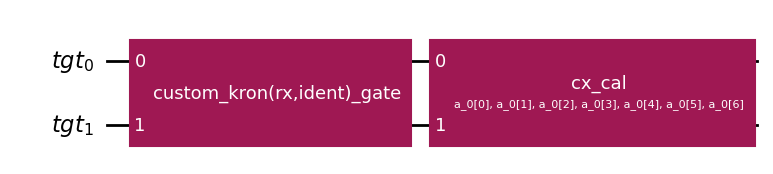

In [17]:
q_env.unwrapped.circuits[0].draw("mpl")

[0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]
[170 169 175 193 195 186 186 204 158 180 184]


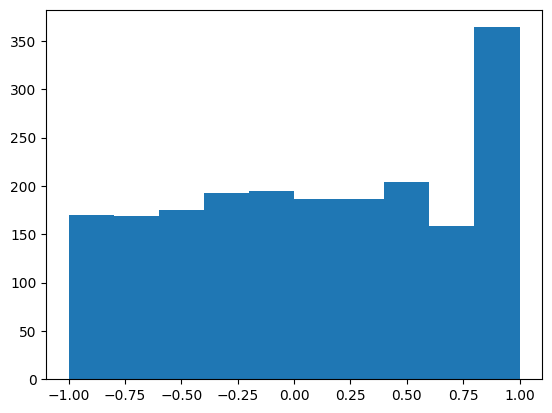

In [18]:
import numpy as np
import matplotlib.pyplot as plt

num_params = 11
batchsize = 2000

prob_weights = np.ones(num_params) / num_params
print(prob_weights)
vals = np.linspace(-1., 1., num_params)
print(vals)

np.random.seed(seed=3)
prob_distr = np.random.choice(vals, size=batchsize, p=prob_weights, replace=True)
unique_vals, counts = np.unique(prob_distr, return_counts=True)
print(counts)

plt.hist(prob_distr)
plt.show()

In [19]:
# Adapted from CleanRL ppo_continuous_action.py
import random
import time
from typing import Optional, Dict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter

from rl_qoc.base_q_env import BaseQuantumEnvironment


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    # torch.nn.init.zeros_(layer.weight)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


def plot_curves(env: BaseQuantumEnvironment):
    """
    Plots the reward history and fidelity history of the environment
    """
    fidelity_range = [i * env.benchmark_cycle for i in range(len(env.fidelity_history))]

    fig, ax = plt.subplots(4, figsize=(8.0, 6.0 * 4))

    ax[0].plot(np.mean(env.reward_history, axis=1), label="Reward")
    ax[0].plot(
        fidelity_range,
        env.fidelity_history,
        label=f"Circuit Fidelity",
    )

    ax[0].set_title("Reward History")
    ax[0].legend()
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Reward")
    # Ensure integer ticks on the x-axis
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1].plot(np.mean(env.rl_reward_history, axis=1), label="RL Reward")

    ax[1].set_title("RL Reward History")
    ax[1].legend()
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("RL Reward")
    # Ensure integer ticks on the x-axis
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[2].errorbar(env.discrete_obs_vals, np.mean(env.discrete_reward_history, axis=0), yerr=np.std(env.discrete_reward_history, axis=0), label="Reward History")
    ax[2].legend()
    ax[2].set_xlabel("Obs Val")
    ax[2].set_ylabel('Reward')

    ax[3].scatter(env.discrete_obs_vals, env.prob_weights, label='Probability Distribution Weights')
    ax[3].legend()
    ax[3].set_xlabel("Obs Val")
    ax[3].set_ylabel('Probability')

    plt.show()


class Agent(nn.Module):
    def __init__(self, env, use_combined_networks, activation_function_str, layer_size, robust_ppo):
        super().__init__()
        self.use_combined_networks = use_combined_networks
        self.robust_ppo = robust_ppo
        if activation_function_str == "tanh":
            self.activation_fn = nn.Tanh
        elif activation_function_str == "relu":
            self.activation_fn = nn.ReLU
        elif activation_function_str == "gelu":
            self.activation_fn = nn.GELU
        elif activation_function_str == "leaky_relu":
            self.activation_fn = nn.LeakyReLU
        elif activation_function_str == "elu":
            self.activation_fn = nn.ELU
        if not self.use_combined_networks:
            self.critic = nn.Sequential(
                layer_init(
                    nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)
                ),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, 1), std=1.0),
            )
            self.actor_mean = nn.Sequential(
                layer_init(
                    nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)
                ),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01),
            )
            self.actor_logstd = nn.Parameter(
                torch.zeros(1, np.prod(env.action_space.shape))
            )
        if self.use_combined_networks:
            self.main_network = nn.Sequential(
                layer_init(
                    nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)
                ),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
            )
            self.actor_mean = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01),
                self.activation_fn(),
            )
            self.actor_std = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01),
                nn.Sigmoid(),
            )
            self.critic = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, 1), std=1.0),
            )
            self.actor_logstd = nn.Parameter(
                torch.zeros(1, np.prod(env.action_space.shape))
            )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        # action_logstd = self.actor_logstd.expand_as(action_mean)
        # action_std = torch.exp(action_logstd)
        if self.use_combined_networks:
            action_std = self.actor_std(x)
        else:
            action_logstd = self.actor_logstd.expand_as(action_mean)
            action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
        )


class PPO_CleanRL:
    def __init__(
        self,
        agent_config: Dict,
        env: BaseQuantumEnvironment,
        chkpt_dir: Optional[str] = "tmp/ppo",
        chkpt_dir_critic: Optional[str] = "tmp/critic_ppo",
    ):
        # General Run Params
        self.agent_config = agent_config
        self.exp_name = self.agent_config["exp_name"]
        self.seed = self.agent_config["seed"]
        self.torch_deterministic = self.agent_config["torch_deterministic"]
        self.cuda = self.agent_config["cuda"]
        self.track = self.agent_config["track"]
        self.wandb_project_name = self.agent_config["wandb_project_name"]
        self.wandb_entity = self.agent_config["wandb_entity"]
        self.save_model = self.agent_config["save_model"]
        self.plot_real_time = self.agent_config["plot_real_time"]
        self.num_prints = self.agent_config["num_prints"]

        # PPO Specific Params
        self.num_updates = self.agent_config["total_updates"]
        self.learning_rate = self.agent_config["learning_rate"]
        self.num_envs = self.agent_config["num_envs"]
        self.num_steps = self.agent_config["num_steps"]
        self.anneal_lr = self.agent_config["anneal_lr"]
        self.anneal_num_updates = self.agent_config["anneal_num_updates"]
        self.exp_anneal_lr = self.agent_config["exp_anneal_lr"]
        self.exp_update_time = self.agent_config["exp_update_time"]
        self.plateau_lr = self.agent_config["plateau_lr"]
        self.gamma = self.agent_config["gamma"]
        self.gae_lambda = self.agent_config["gae_lambda"]
        self.num_minibatches = self.agent_config["num_minibatches"]
        self.update_epochs = self.agent_config["update_epochs"]
        self.norm_adv = self.agent_config["norm_adv"]
        self.activation_function_str = self.agent_config["activation_function_str"]
        self.use_combined_networks = self.agent_config["use_combined_networks"]
        self.layer_size = self.agent_config["layer_size"]
        self.clip_coef = self.agent_config["clip_coef"]
        self.clip_vloss = self.agent_config["clip_vloss"]
        self.ent_coef = self.agent_config["ent_coef"]
        self.vf_coef = self.agent_config["vf_coef"]
        self.max_grad_norm = self.agent_config["max_grad_norm"]
        self.target_kl = self.agent_config["target_kl"]
        self.robust_ppo = self.agent_config["robust_ppo"]

        self.batch_size = int(self.num_envs * self.num_steps)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)

        assert self.anneal_lr + self.exp_anneal_lr, "Learning Rate Combination doesn't work"

        self.run_name = f"PPO_CleanRL__{self.exp_name}__{self.seed}__{int(time.time())}"

        if self.track:
            import wandb

            wandb.init(
                project=self.wandb_project_name,
                entity=self.wandb_entity,
                sync_tensorboard=True,
                config=self.agent_config,
                name=self.run_name,
                monitor_gym=True,
                save_code=True,
            )
        self.writer = SummaryWriter(f"runs/{self.run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s"
            % (
                "\n".join(
                    [f"|{key}|{value}|" for key, value in self.agent_config.items()]
                )
            ),
        )

        # TRY NOT TO MODIFY: seeding
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = self.torch_deterministic

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() and self.cuda else "cpu"
        )

        self.env = env

        self.agent = Agent(
            self.env,
            self.use_combined_networks,
            self.activation_function_str,
            self.layer_size,
            self.robust_ppo
        ).to(self.device)
        self.optimizer = optim.Adam(
            self.agent.parameters(), lr=self.learning_rate, eps=1e-5
        )

    def run_training(self):
        # ALGO Logic: Storage setup
        self.obs = torch.zeros(
            (self.num_steps, self.num_envs) + self.env.observation_space.shape
        ).to(self.device)
        self.actions = torch.zeros(
            (self.num_steps, self.num_envs) + self.env.action_space.shape
        ).to(self.device)
        self.logprobs = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.rewards = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.dones = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.values = torch.zeros((self.num_steps, self.num_envs)).to(self.device)

        # TRY NOT TO MODIFY: start the game
        global_step = 0
        start_time = time.time()
        next_obs, _ = self.env.reset(seed=self.seed)
        next_obs = np.tile(next_obs, (self.num_envs, 1))
        next_obs = torch.Tensor(next_obs).to(self.device)
        next_done = torch.zeros(self.num_envs).to(self.device)

        for update in range(1, self.num_updates + 1):
            # Annealing the Learning Rate
            if self.anneal_lr or self.exp_anneal_lr:
                if self.anneal_lr:
                    frac = 1.0 - (update - 1.0) / self.anneal_num_updates
                    lrnow = np.clip(frac, a_min=0., a_max=None) * self.learning_rate + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow
                if self.exp_anneal_lr:
                    lrnow = self.learning_rate * np.exp(-update / self.exp_update_time) + self.plateau_lr
                    self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.num_steps):
                global_step += self.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done

                # ALGO LOGIC: action logic
                with torch.no_grad():
                    action, logprob, _, value = self.agent.get_action_and_value(
                        next_obs
                    )
                    self.values[step] = value.flatten()
                self.actions[step] = action
                self.logprobs[step] = logprob

                # TRY NOT TO MODIFY: execute the game and log data.
                cpu_action = action.cpu().numpy()
                cpu_action = np.clip(
                    cpu_action,
                    self.env.action_space.low,
                    self.env.action_space.high,
                )

                next_obs, reward, terminations, truncations, infos = self.env.step(
                    cpu_action
                )
                print(f"Mean Action: {np.mean(cpu_action, axis=0)}")
                next_obs = np.tile(next_obs, (self.num_envs, 1))
                next_done = np.logical_or(terminations, truncations)
                if next_done:
                    next_obs, _ = self.env.reset(seed=self.seed)
                    next_obs = np.tile(next_obs, (self.num_envs, 1))
                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs, next_done = torch.Tensor(next_obs).to(
                    self.device
                ), torch.Tensor(next_done).to(self.device)

                if "final_info" in infos:
                    for info in infos["final_info"]:
                        if info and "episode" in info:
                            print(
                                f"global_step={global_step}, episodic_return={info['episode']['r']}"
                            )
                            self.writer.add_scalar(
                                "charts/episodic_return",
                                info["episode"]["r"],
                                global_step,
                            )
                            self.writer.add_scalar(
                                "charts/episodic_length",
                                info["episode"]["l"],
                                global_step,
                            )

            # bootstrap value if not done
            with torch.no_grad():
                next_value = self.agent.get_value(next_obs).reshape(1, -1)
                advantages = torch.zeros_like(self.rewards).to(self.device)
                lastgaelam = 0
                for t in reversed(range(self.num_steps)):
                    if t == self.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - self.dones[t + 1]
                        nextvalues = self.values[t + 1]
                    delta = (
                        self.rewards[t]
                        + self.gamma * nextvalues * nextnonterminal
                        - self.values[t]
                    )
                    advantages[t] = lastgaelam = (
                        delta
                        + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
                    )
                returns = advantages + self.values

            # flatten the batch
            b_obs = self.obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape((-1,) + self.env.action_space.shape)
            b_advantages = advantages.reshape(-1)
            b_returns = returns.reshape(-1)
            b_values = self.values.reshape(-1)

            # Optimizing the policy and value network
            b_inds = np.arange(self.batch_size)
            clipfracs = []
            for epoch in range(self.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.batch_size, self.minibatch_size):
                    end = start + self.minibatch_size
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy, newvalue = self.agent.get_action_and_value(
                        b_obs[mb_inds], b_actions[mb_inds]
                    )
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        # calculate approx_kl http://joschu.net/blog/kl-approx.html
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [
                            ((ratio - 1.0).abs() > self.clip_coef).float().mean().item()
                        ]

                    mb_advantages = b_advantages[mb_inds]
                    if self.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (
                            mb_advantages.std() + 1e-8
                        )

                    # Policy loss
                    pg_loss1 = -mb_advantages * ratio
                    pg_loss2 = -mb_advantages * torch.clamp(
                        ratio, 1 - self.clip_coef, 1 + self.clip_coef
                    )
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    newvalue = newvalue.view(-1)
                    if self.clip_vloss:
                        v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                        v_clipped = b_values[mb_inds] + torch.clamp(
                            newvalue - b_values[mb_inds],
                            -self.clip_coef,
                            self.clip_coef,
                        )
                        v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                        v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                        v_loss = 0.5 * v_loss_max.mean()
                    else:
                        v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    entropy_loss = entropy.mean()
                    loss = (
                        pg_loss - self.ent_coef * entropy_loss + v_loss * self.vf_coef
                    )

                    self.optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(
                        self.agent.parameters(), self.max_grad_norm
                    )
                    self.optimizer.step()

                if self.target_kl is not None and approx_kl > self.target_kl:
                    break

            y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = (
                np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
            )

            # TRY NOT TO MODIFY: record rewards for plotting purposes
            self.writer.add_scalar(
                "charts/learning_rate",
                self.optimizer.param_groups[0]["lr"],
                global_step,
            )
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.writer.add_scalar(
                "losses/old_approx_kl", old_approx_kl.item(), global_step
            )
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            self.writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
            self.writer.add_scalar(
                "losses/explained_variance", explained_var, global_step
            )
            print("SPS:", int(global_step / (time.time() - start_time)))
            self.writer.add_scalar(
                "charts/SPS", int(global_step / (time.time() - start_time)), global_step
            )

            if global_step % self.num_prints == 0:
                clear_output(wait=True)
                if self.plot_real_time:
                    plot_curves(self.env.unwrapped)

        if self.save_model:
            model_path = f"runs/{self.run_name}/{self.exp_name}.cleanrl_model"
            torch.save(self.agent.state_dict(), model_path)
            print(f"model saved to {model_path}")

        self.env.close()
        self.writer.close()

In [20]:
agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 600,
    "learning_rate": 3e-5,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 400,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "tanh",
    "use_combined_networks": True,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

ppo_agent = PPO_CleanRL(agent_config, q_env)

In [21]:
print(ppo_agent.env.discrete_reward_history.shape)
print(np.mean(ppo_agent.env.discrete_reward_history, axis=0))
print(ppo_agent.env.discrete_obs_vals.shape)
print(ppo_agent.env.action_space.low)

(3, 17)
[1.         0.93141847 1.         1.         1.         1.
 1.         1.         1.         1.         2.33333333 1.
 1.         1.         1.         1.         1.        ]
(17,)
[-3.14 -3.14 -3.14 -3.14 -3.14 -3.14 -3.14]


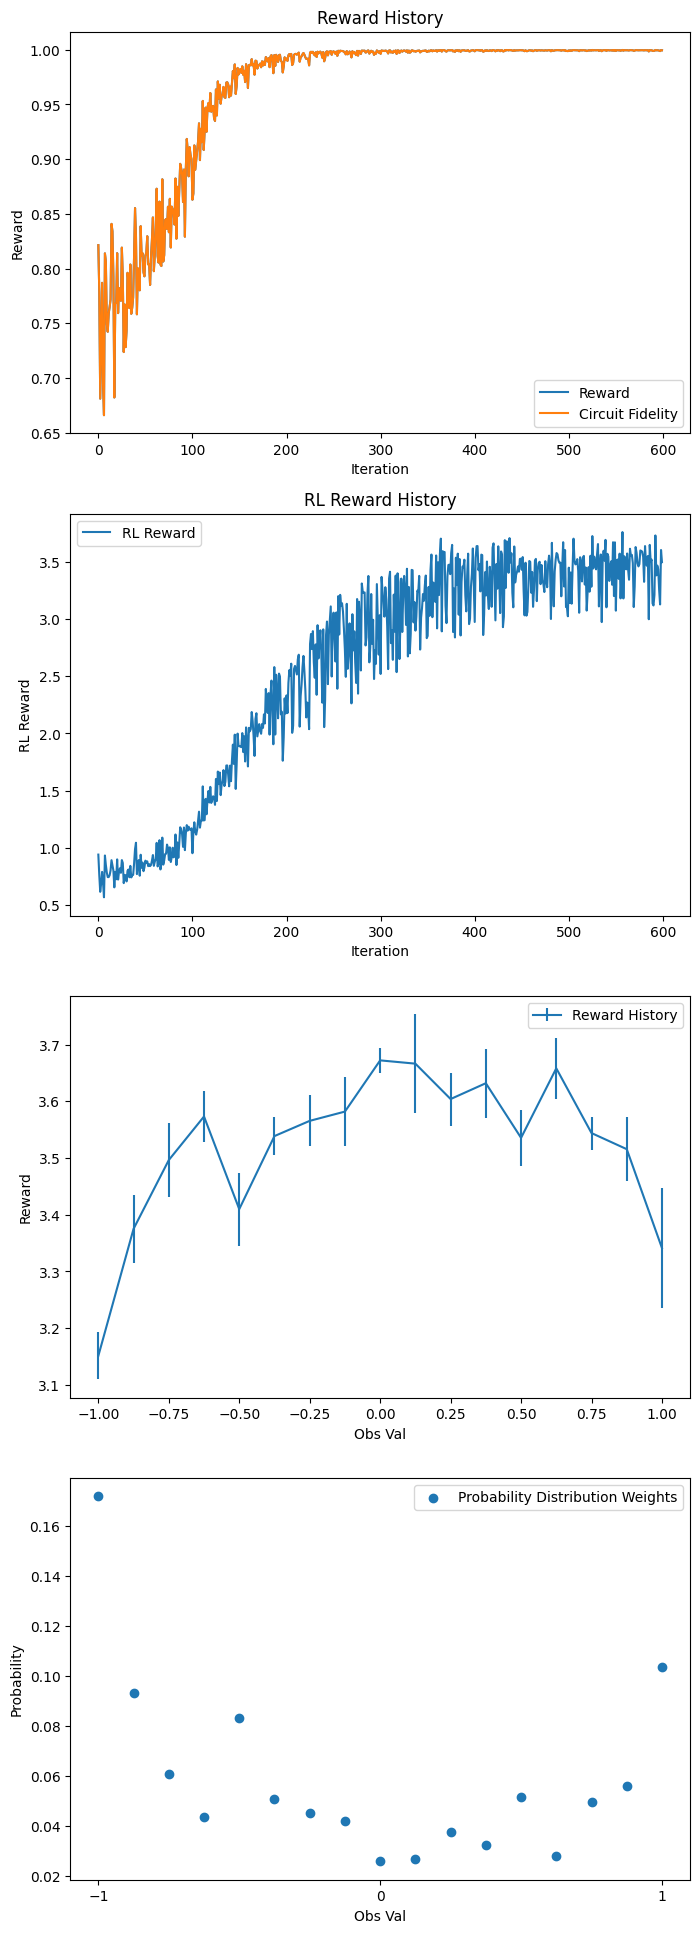

model saved to runs/PPO_CleanRL__Test PPO CleanRL__1__1724204973/Test PPO CleanRL.cleanrl_model


In [22]:
q_env.clear_history()
ppo_agent.run_training()

In [23]:
print(ppo_agent.env.discrete_obs_vals)

[-1.    -0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125  0.     0.125
  0.25   0.375  0.5    0.625  0.75   0.875  1.   ]


In [24]:
# Evaluating Policy across Parameter Space

import torch

obs_linspace = np.linspace(-1.0, 1.0, 51)

mean_reward = np.zeros_like(obs_linspace)
std_reward = np.zeros_like(obs_linspace)
mean_actions = np.zeros((len(obs_linspace),) + q_env.action_space.shape)
std_actions = np.zeros((len(obs_linspace),) + q_env.action_space.shape)

for i, test_obs in enumerate(obs_linspace):
    test_obs, _ = ppo_agent.env.reset(seed=ppo_agent.seed, override_obs=test_obs)
    batch_test_obs = np.tile(test_obs, (ppo_agent.num_envs, 1))
    with torch.no_grad():
        action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_test_obs)
        )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        ppo_agent.env.action_space.low,
        ppo_agent.env.action_space.high,
    )

    played_action = cpu_action
    # played_action[:, 0] = 0.
    # played_action[:, 1] = 0.
    # played_action[:, 2] = 0.
    # played_action[:, 4] = 0.
    # played_action[:, 5] = 0.
    # played_action[:, 3] = -0.5 * q_env.gamma * test_obs * np.pi + 0.25
    # played_action[:, 6] = 0.5 * q_env.gamma * test_obs * np.pi + 0.25

    mean_actions[i] = np.mean(played_action, axis=0)
    std_actions[i] = np.std(played_action, axis=0)

    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        played_action
    )
    mean_reward[i] = np.mean(reward)
    std_reward[i] = np.std(reward)

/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9991098814879024
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9993526831500384
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9994870384067535
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9993436619301848
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9995819233201195
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9992867174368594
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996172728049516
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.999580450010197
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9994970631798292
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9994989197867016
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9995501681994544
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.999652680926903
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9995400640654557
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996348729194049
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9994418448583102
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9995877880786447
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996640988715186
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996049754997258
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996066893328095
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996283621480437
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997364776793454
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997545278396223
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9998025692318201
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997584439217018
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997843891517456
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator') has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator') has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997978641792905
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9998000445032751
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9998163544692007
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997313669710846
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.999803394617222
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997668602913659
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997534308574461
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996658029150061
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996205973975986
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996574384608383
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997939145925396
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996722048677942
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997239626440546
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9995919419550613
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996563219545755
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996573702254364
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997093987719088
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996836748291678
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996783878323732
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9997641243050471
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996846250775983
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9996417329842491
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9994577996403126
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9994989969490946
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9991660845844965
(1,)
(32,)
Fidelity stored 0.9991209428639112
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


3.7740517577766477


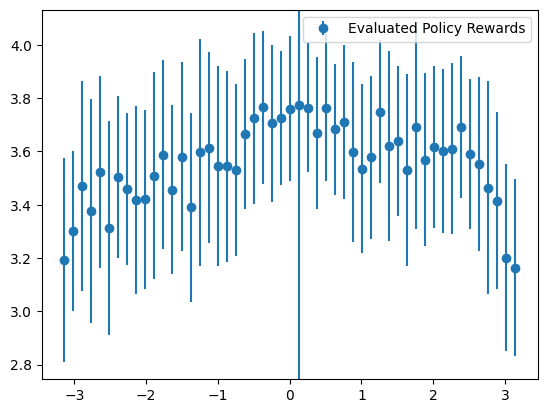

In [26]:
import matplotlib.pyplot as plt

mean_fidelity = 1. - 10**(-mean_reward)
std_fidelity = 1. - 10**(-std_reward)

obs_rad_linspace = obs_linspace * np.pi

print(np.max(mean_reward))

plt.errorbar(obs_rad_linspace, mean_reward, yerr=std_reward, fmt="o", label='Evaluated Policy Rewards')
plt.axvline(x=obs_rad_linspace[np.argmax(mean_reward)])
plt.legend()
plt.show()

In [27]:
print(ppo_agent.obs.shape)

torch.Size([1, 32, 1])


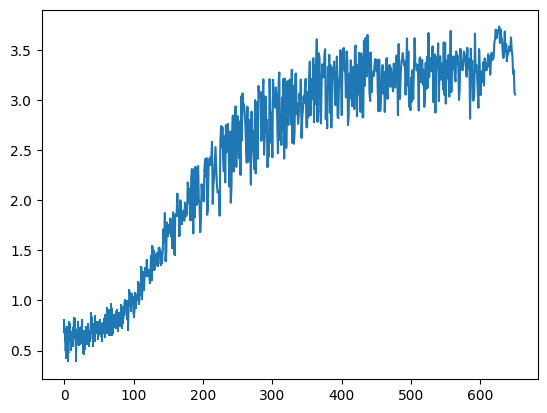

In [28]:
reward_hist = np.array(q_env.reward_history)

pf_mean_hist = -np.log10(1. - np.mean(reward_hist, axis=1))
pf_std_hist = -np.log10(1. - np.std(reward_hist, axis=1))

plt.errorbar(np.arange(len(reward_hist)), pf_mean_hist, yerr=pf_std_hist)
plt.show()

[[-2.25193286e-03  3.51546258e-02  2.76137739e-01  5.70612133e-01
  -4.23651077e-02 -4.96658646e-02 -3.28356147e-01]
 [-1.33653800e-03  1.81385323e-01  4.36828494e-01  5.63252389e-01
  -3.97507586e-02 -5.56993708e-02 -3.15008372e-01]
 [-4.53636516e-03  1.06929038e-02  3.52190912e-01  5.45740187e-01
  -4.39931080e-02 -5.16052879e-02 -2.98519343e-01]
 [-5.02966624e-03  4.70714495e-02  3.13045502e-01  5.26723146e-01
  -3.76090892e-02 -5.06050475e-02 -2.85728514e-01]
 [-4.98519000e-03  5.71150780e-02  2.24864274e-01  5.10371208e-01
  -3.16675231e-02 -5.01827560e-02 -2.67616451e-01]
 [-1.87280052e-03  8.93799737e-02  2.50681520e-01  5.03729641e-01
  -4.58045714e-02 -3.61755863e-02 -2.47925133e-01]
 [-2.62326270e-04  1.54881552e-02  2.66636044e-01  4.93556052e-01
  -3.60654928e-02 -4.53606397e-02 -2.24266380e-01]
 [-4.44081239e-03  8.87579918e-02  3.46121341e-01  4.77892816e-01
  -3.67523246e-02 -5.04158884e-02 -2.04641595e-01]
 [-2.62884167e-03  1.66785508e-01  2.71049917e-01  4.69671309e-0

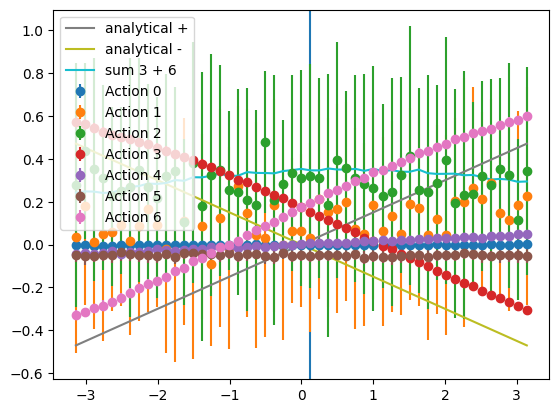

In [29]:
print(mean_actions)
print(mean_actions[np.argmax(mean_reward)])
plt.axvline(x=obs_rad_linspace[np.argmax(mean_reward)])
for i in range(len(mean_actions.T)):
    plt.errorbar(obs_rad_linspace, mean_actions[:, i], yerr=std_actions[:, i], fmt="o", label=f'Action {i}')
plt.plot(obs_rad_linspace, obs_rad_linspace * 0.15, label='analytical +')
plt.plot(obs_rad_linspace, -obs_rad_linspace * 0.15, label='analytical -')
plt.plot(obs_rad_linspace, mean_actions[:, 3] + mean_actions[:, 6], label='sum 3 + 6')
plt.legend()
plt.show()

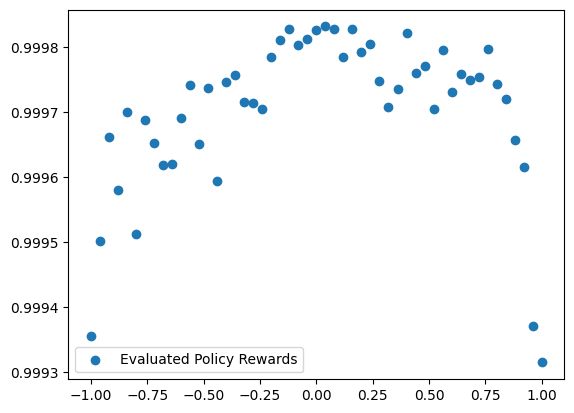

In [30]:
plt.scatter(obs_linspace, mean_fidelity, label='Evaluated Policy Rewards')
plt.legend()
plt.show()

In [31]:
# Evaluating Policy across Parameter Space

import torch

obs_linspace = np.linspace(-1.0, 1.0, 21)

zeros_mean_reward = np.zeros_like(obs_linspace)
zeros_std_reward = np.zeros_like(obs_linspace)

for i, test_obs in enumerate(obs_linspace):
    test_obs, _ = ppo_agent.env.reset(seed=ppo_agent.seed, override_obs=test_obs)
    batch_test_obs = np.tile(test_obs, (ppo_agent.num_envs, 1))
    with torch.no_grad():
        action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_test_obs)
        )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        ppo_agent.env.action_space.low,
        ppo_agent.env.action_space.high,
    )
    cpu_action = np.zeros_like(cpu_action)

    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        cpu_action
    )
    zeros_mean_reward[i] = np.mean(reward)
    zeros_std_reward[i] = np.std(reward)

/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.7938926261462362
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.8306559326618255
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.8644843137107057
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.8950775061878449
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9221639627510073
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9455032620941837
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9648882429441255
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9801468428384712
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9911436253643444
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.99778098230154
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator') has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator') has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9999999999999998
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.99778098230154
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9911436253643444
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9801468428384716
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9648882429441259
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9455032620941841
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.9221639627510079
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.8950775061878453
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.8644843137107061
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


Fidelity stored 0.8306559326618265
(1,)
(32,)
Fidelity stored 0.7938926261462371
(1,)
(32,)


/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(
/Users/chatt07/Desktop/new_context_env/lib/python3.9/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>) has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


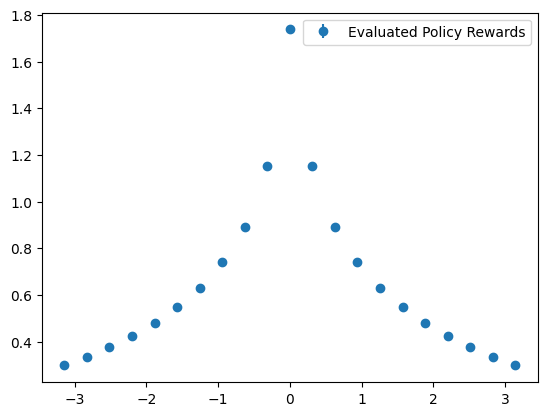

In [32]:
zeros_mean_fidelity = 1. - np.exp(-zeros_mean_reward)
zeros_std_fidelity = 1. - np.exp(-zeros_std_reward)

plt.errorbar(obs_linspace * np.pi, zeros_mean_reward * np.log10(np.e), yerr=zeros_std_reward * np.log10(np.e), fmt="o", label='Evaluated Policy Rewards')
plt.legend()
plt.show()

In [ ]:
### Nearly 3 9s all over ###

# agent_config = {
#     "exp_name": "Test PPO CleanRL",
#     "seed": 1,
#     "torch_deterministic": True,
#     "cuda": False,
#     "track": False,
#     "wandb_project_name": "Context Aware Calibrations",
#     "wandb_entity": None,
#     "save_model": True,
#     "plot_real_time": True,
#     "num_prints": 5,
#     "total_updates": 600,
#     "learning_rate": 3e-5,
#     "num_envs": 32,
#     "num_steps": 1,
#     "anneal_lr": True,
#     "anneal_num_updates": 400,
#     "exp_anneal_lr": False,
#     "exp_update_time": 100,
#     "plateau_lr": 1e-6,
#     "gamma": 0.99,
#     "gae_lambda": 0.95,
#     "num_minibatches": 4,
#     "update_epochs": 8,
#     "norm_adv": True,
#     "activation_function_str": "tanh",
#     "use_combined_networks": True,
#     "layer_size": 64,
#     "clip_coef": 0.2,
#     "clip_vloss": True,
#     "ent_coef": 0.,
#     "vf_coef": 0.5,
#     "max_grad_norm": 0.5,
#     "target_kl": None
# }